# Evaluate climate projections of different climate models and scenarios

## Introduction

Nokebook for the workflow **Snakefile_climate_projections**: 

1. Extracts CMIP6 data for the region of interest.
2. derives historical and future climate statistics (projected precipitation, temperature, potential evaporation) for different climate models and scenarios.
3. Derives change statistics as well as monthly gridded change factors which can be used to run a hydrological model for future projections based on a delta change approach (this is the topic of the next notebook *docs/notebooks/Hydrological projections.ipynb*).
4. Plots of the climate projections and climate change factors.

In [1]:
# Import some python libraries we will need to run this notebook
import os
import xarray as xr
from IPython import display

In [2]:
# A helper function
from subprocess import Popen, PIPE, STDOUT

from IPython.core.magic import register_line_magic


@register_line_magic
def runrealcmd(command):
    with Popen(
        command, stdout=PIPE, shell=True, stderr=STDOUT, bufsize=1, close_fds=True
    ) as process:
        for line in iter(process.stdout.readline, b""):
            print(line.rstrip().decode("utf-8"))

## Choosing your climate datasets and scenarios

First thing is to prepare all the options for your project, this is done using the configuration or settings file below

In [3]:
# Add here the path where you have installed the blueearth-cst tool
cst_path = r'c:\repos\blueearth_cst'
os.chdir(cst_path)

To extract data for your basin or region of interest, you will need to provide one of the following options in the ``model_region`` argument

The location can either be:
- for a basin to the sea, any point in the basin [x, y]
- for a subbasin (tributary or part of a basin) the location of the subbasin outlet [xout, yout]
- a bounding box [xmin, ymin, xmax, ymax]
- a geometry file of your region of interest (eg, myregion.shp)

For more details on the exact syntax, please have a look at:
https://deltares.github.io/hydromt/stable/user_guide/model_region.html

The coordinates should be in EPSG 4326.
For points, you can use Google Maps to locate your coordinates.
For bounding box or point cooridnates, you can also copy-paste locations from this website: http://bboxfinder.com/

In [4]:
%%writefile ./config/my-project-settings.yml

########################################################################################
#################################### General settings ##################################

# Path to where the wflow model will be stored (include the project name)
project_dir: examples/myModel

# hydromt "region" for building the model, coordinates are in EPSG 4326
# for more info on how to fill this, please check the hydromt documentation: 
# https://deltares.github.io/hydromt/stable/user_guide/model_region.html#hydrographic-region 
# For wflow please use either 'basin' or 'subbasin' keywords
model_region: "{'subbasin': [12.3758, 46.4076], 'uparea': 70}"

# Path to the data catalog to use (can be different for Linux/Windows/data stored on P drive or other)
# NB: should in order of priority! 
data_sources: 
  - artifact_data
  - tests/data/tests_data_catalog.yml

    
###########################################################################################
################################## Climate projections ####################################
# climate models and scenarios
clim_project: cmip6
# Path to the data catalog to use (can be different for Linux/Windows/data stored on P drive or other)
data_sources_climate: config/cmip6_data.yml
# Available models: ['NOAA-GFDL_GFDL-ESM4', 'INM_INM-CM4-8' ,'INM_INM-CM5-0','NIMS-KMA_KACE-1-0-G','NCC_NorESM2-MM','NCC_NorESM2-LM','CMCC_CMCC-CM2-SR5','CMCC_CMCC-ESM2']
models: ['NOAA-GFDL_GFDL-ESM4', 'INM_INM-CM5-0', 'CSIRO-ARCCSS_ACCESS-CM2']
# Available scenarios: [ssp126, ssp245, ssp370, ssp585]
scenarios: [ssp245, ssp585]
members: [r1i1p1f1]

# Climate projections for the following variables
# Allowed variables: [precip, temp, temp_dew, ssr, tcc, wind, pet]
# If temp_dew not available, can be computed from temp [°C] and relative humidity rh [%]
# If wind not available, can be computed from the u and v components: wind10_u and wind10_v [m/s]
# PET can also be computed from several equations/variables (see below)
variables: [precip, temp, pet]

# Method to compute PET if not available in the climate data - None to use pet in the climate data
# Available methods: 'None', 'makkink' 'debruin', 'penman-monteith_rh_simple', 'penman-monteith_tdew'
# Required variables are: 'temp' [°C], 'press_msl' [hPa], 'kin'[W/m2] for makkink
# 'temp' [°C], 'press_msl' [hPa], 'kin' [W/m2], 'kout' [W/m2] for debruin
pet_method: makkink
# Method to compute temp_dew if not available - None to use temp_dew in the climate data
# Available method: 'None', 'rh' for relative humidity, 'sh' for specific humidity
# Required variables are: 'temp' [°C], 'rh' [%] for rh method
# 'temp' [°C], 'sh' [%], 'press_msl' [hPa] for sh method
tdew_method: sh
# Calculate wind using u and v components
compute_wind: False

# time horizons of the climate projections
start_month_hyd_year: JAN
historical: 2000, 2010
future_horizons: 
  near: 2050, 2060
  far: 2090, 2100

# Additional gridded outputs (else only basin average)
save_grids: TRUE
# Threshold to apply to avoid too large change factors for dry months [mm/month]
change_drymonth_threshold: 3.0
# Maximum change factor for dry months [%]
change_drymonth_maxchange: 50

Writing ./config/my-project-settings.yml


The workflow allows you to analyse CMIP6 projections and you can decide which ``models`` and ``scenarios`` to analyse. To calculate change in climate compared to historical, you can defined what is the reference period in ``historical`` and you can choose several ``future_horizons`` periods (the subsequent Hydrological projections workflow **Snakefile_future_hydrology_delta_change** expects near and far future periods).

The workflow can analyse changes for different climate variables listed in ``variables``. Avaialable variables are \[precip, temp, temp_dew, ssr, tcc, wind, pet]. If some variables are not available in CMIP6, the workflows can compute then. This is the case for potential evapotranspiration which can be computed from other climate variables with ``pet_method`` or dewpoint temperature which can be computed with ``tdew_method``. If average wind speed is not directly available, the U- and V- component of the wind can also be summed up using ``compute_wind``.

Finally, by default the worfklow only saves change statistics averaged over the region of interest. To also analyse gridded changes and gridded monthly change factors, set the ``save_grids`` to TRUE.

## Running the model building workflow

The workflow can be run using the snakemake command line interface.

The first line is to create an image of our workflow with snakemake to verify that all our settings are well taken into account.

In [5]:
! snakemake -s snakemake/Snakefile_climate_projections.smk --configfile config/my-project-settings.yml --dag | dot -Tpng > dag_climate_projections.png

Building DAG of jobs...


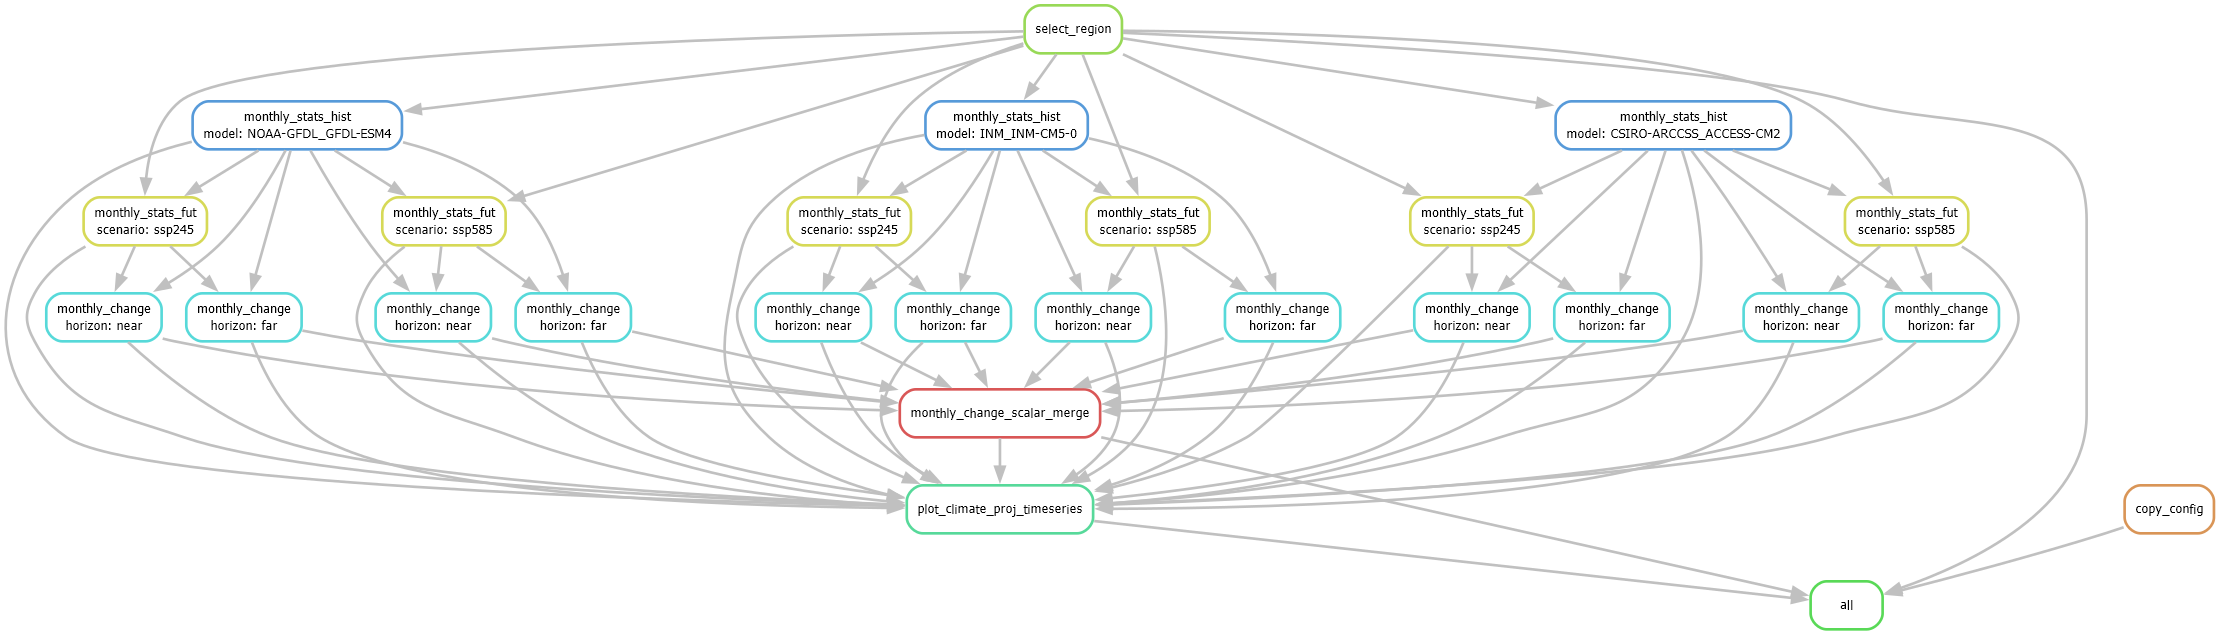

In [6]:
display.Image("./dag_climate_projections.png")

Let's have a closer look at the different rules within this workflow:

1. **select_region**: this rule selects the region of interest based on the arguments provided by the users in ``model_region`` of the config file and considering a ``region_buffer`` around the area of interest. A geojson file is created.    
2. **monthly_stats_hist**: calculates monthly scalar and gridded statistics over the historical period of each climate model. The historical period is provided in the config file under ``historical``. The selected climate project (e.g. CMIP6) is provided in the config file under ``clim_project`` and the data catalog for the climate data is given in ``data_sources_climate``. The list of selected climate models is given under ``models``. The statistics are calculated for the climate variables under ``variables``. If potential evaporation (pet) is included in the list, the method to estimate potential evaporation must be provided under ``pet_method``. Gridded and scalar netcdf with the monthly statistics over the historical period are saved by this rule.  
3. **monthly_stats_fut**: calculates monthly scalar and gridded statistics over the future period of each climate model for a specific scenario and future horizon (near of far future). The selected climate scenarios, members, and future horizons names and periods are provided under ``scenarios``, ``members`` and ``future_horizons`` of the config file. Gridded and scalar netcdf with the monthly statistics over the future periods are saved by this rule.  
4. **monthly_change**: based on the derived monthly statistics for the historical and future period for each climate model, gridded and scalar monthly change factors are calculated. 
5. **monthly_change_scalar_merge**: the derived scalar statistics describing the future change of each climate model, scenario and period are then summarized in summary files.
6. **plot_climate_proj_timeseries**: this rule creates plots showing the projected change in all the climate variables. 
7. **copy_config**: all configuration files are saved to make the workflow reproducible. 

Now we will unlock your directory in order to save the future results of the workflow. This step is most of the time not necessary.

In [7]:
! snakemake --unlock -s snakemake/Snakefile_climate_projections.smk --configfile config/my-project-settings.yml

Building DAG of jobs...
Unlocked working directory.


Snakemake also allows us to run a so-called *dryrun*, which will not actually run the workflow, but just print an overview of the rules that will be executed.

In [ ]:
! snakemake all -c 1 -s snakemake/Snakefile_climate_projections.smk --configfile config/my-project-settings.yml --dryrun

And finally let's run our worflow:

In [ ]:
%runrealcmd snakemake all -c 1 -s snakemake/Snakefile_climate_projections.smk --configfile config/my-project-settings.yml

## Results

First check that snake did run everything.

In [10]:
! snakemake -s snakemake/Snakefile_climate_projections.smk --configfile config/my-project-settings.yml --dag | dot -Tpng > dag_climate_projections.png

Building DAG of jobs...


When a rule was successfully executed, it will show with a dotted line in the diagram below. 

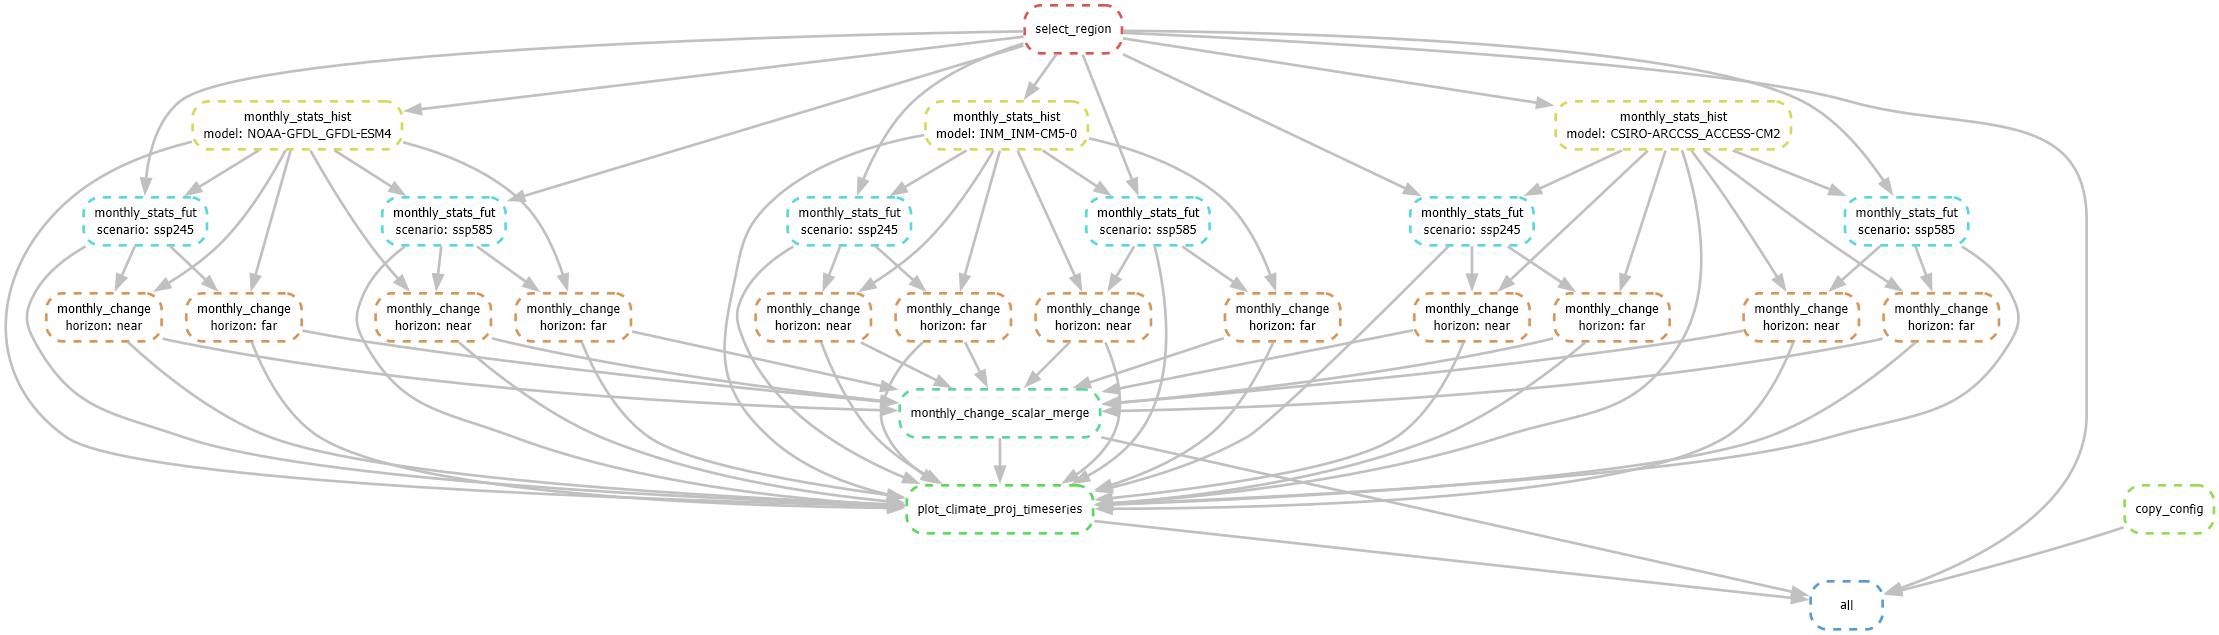

In [11]:
display.Image("./dag_climate_projections.png")

Let's see which files where created in our output folder. The location of the output folder is defined in the config file under ``project_dir``. The results of this workflow are stored in the directory *climate_projections*. The plots are saved in *examples/myModel/plots/climate_projections*.

In [12]:
root = "examples/myModel/climate_projections"
for path, _, files in os.walk(root):
    print(path)
    for name in files:
        if name.endswith(".xml"):
            continue
        print(f" - {name}")

examples/myModel/climate_projections
examples/myModel/climate_projections\cmip6
 - annual_change_scalar_stats_summary.csv
 - annual_change_scalar_stats_summary.nc
 - annual_change_scalar_stats_summary_mean.csv
 - gcm_grid_factors_025.nc
 - gcm_timeseries.nc
examples/myModel/climate_projections\cmip6\monthly_change_grid
 - CSIRO-ARCCSS_ACCESS-CM2_ssp245_far.nc
 - CSIRO-ARCCSS_ACCESS-CM2_ssp245_near.nc
 - CSIRO-ARCCSS_ACCESS-CM2_ssp585_far.nc
 - CSIRO-ARCCSS_ACCESS-CM2_ssp585_near.nc
 - INM_INM-CM5-0_ssp245_far.nc
 - INM_INM-CM5-0_ssp245_near.nc
 - INM_INM-CM5-0_ssp585_far.nc
 - INM_INM-CM5-0_ssp585_near.nc
 - NOAA-GFDL_GFDL-ESM4_ssp245_far.nc
 - NOAA-GFDL_GFDL-ESM4_ssp245_near.nc
 - NOAA-GFDL_GFDL-ESM4_ssp585_far.nc
 - NOAA-GFDL_GFDL-ESM4_ssp585_near.nc


In [13]:
root = "examples/myModel/plots/climate_projections"
for path, _, files in os.walk(root):
    print(path)
    for name in files:
        if name.endswith(".xml"):
            continue
        print(f" - {name}")

examples/myModel/plots/climate_projections
 - pet_anomaly_projections_abs.png
 - pet_anomaly_projections_anom.png
 - pet_monthly_projections_abs.png
 - pet_monthly_projections_anom.png
 - precip_anomaly_projections_abs.png
 - precip_anomaly_projections_anom.png
 - precip_monthly_projections_abs.png
 - precip_monthly_projections_anom.png
 - projected_climate_pet_statistics.png
 - projected_climate_statistics.png
 - temp_anomaly_projections_abs.png
 - temp_anomaly_projections_anom.png
 - temp_monthly_projections_abs.png
 - temp_monthly_projections_anom.png
examples/myModel/plots/climate_projections\grid
 - gridded_monthly_pet_change_ssp245_far-future-horizon.png
 - gridded_monthly_pet_change_ssp245_near-future-horizon.png
 - gridded_monthly_pet_change_ssp585_far-future-horizon.png
 - gridded_monthly_pet_change_ssp585_near-future-horizon.png
 - gridded_monthly_precipitation_change_ssp245_far-future-horizon.png
 - gridded_monthly_precipitation_change_ssp245_near-future-horizon.png
 - gridd

Now let's have a look at the produced plots!

The projected mean annual change in precipitation and temperature for each climate model (grouped according to scenario) and each future horizon is shown below.

In this example of the Piave basin, all climate models project an increase in temperature for the near and the far future. In contrast, some models project an increase in precipitation while others project a decrease in mean annual precipitation. 

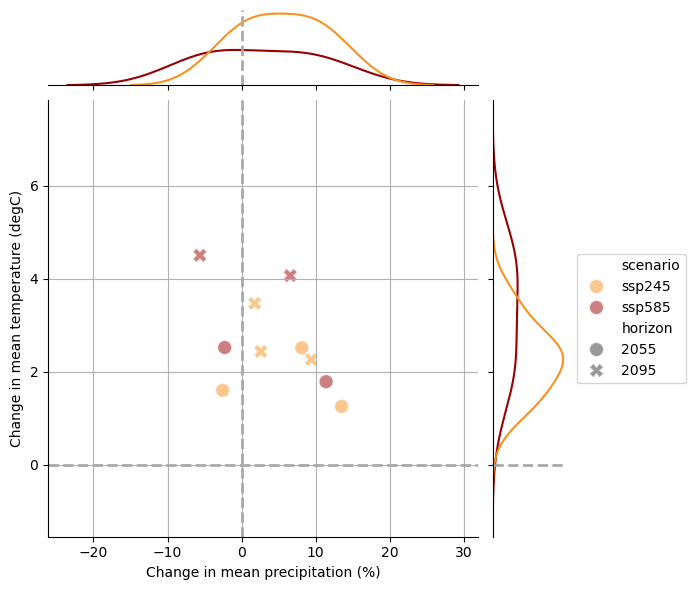

In [14]:
display.Image("./examples/myModel/plots/climate_projections/projected_climate_statistics.png")

In addition, the workflow generates plots which show the evolution of precipitation, temperature and potential evaporation anomalies over the historical and future periods, as multi-model mean for each scenario. This is shown below for temperature and precipitation. 

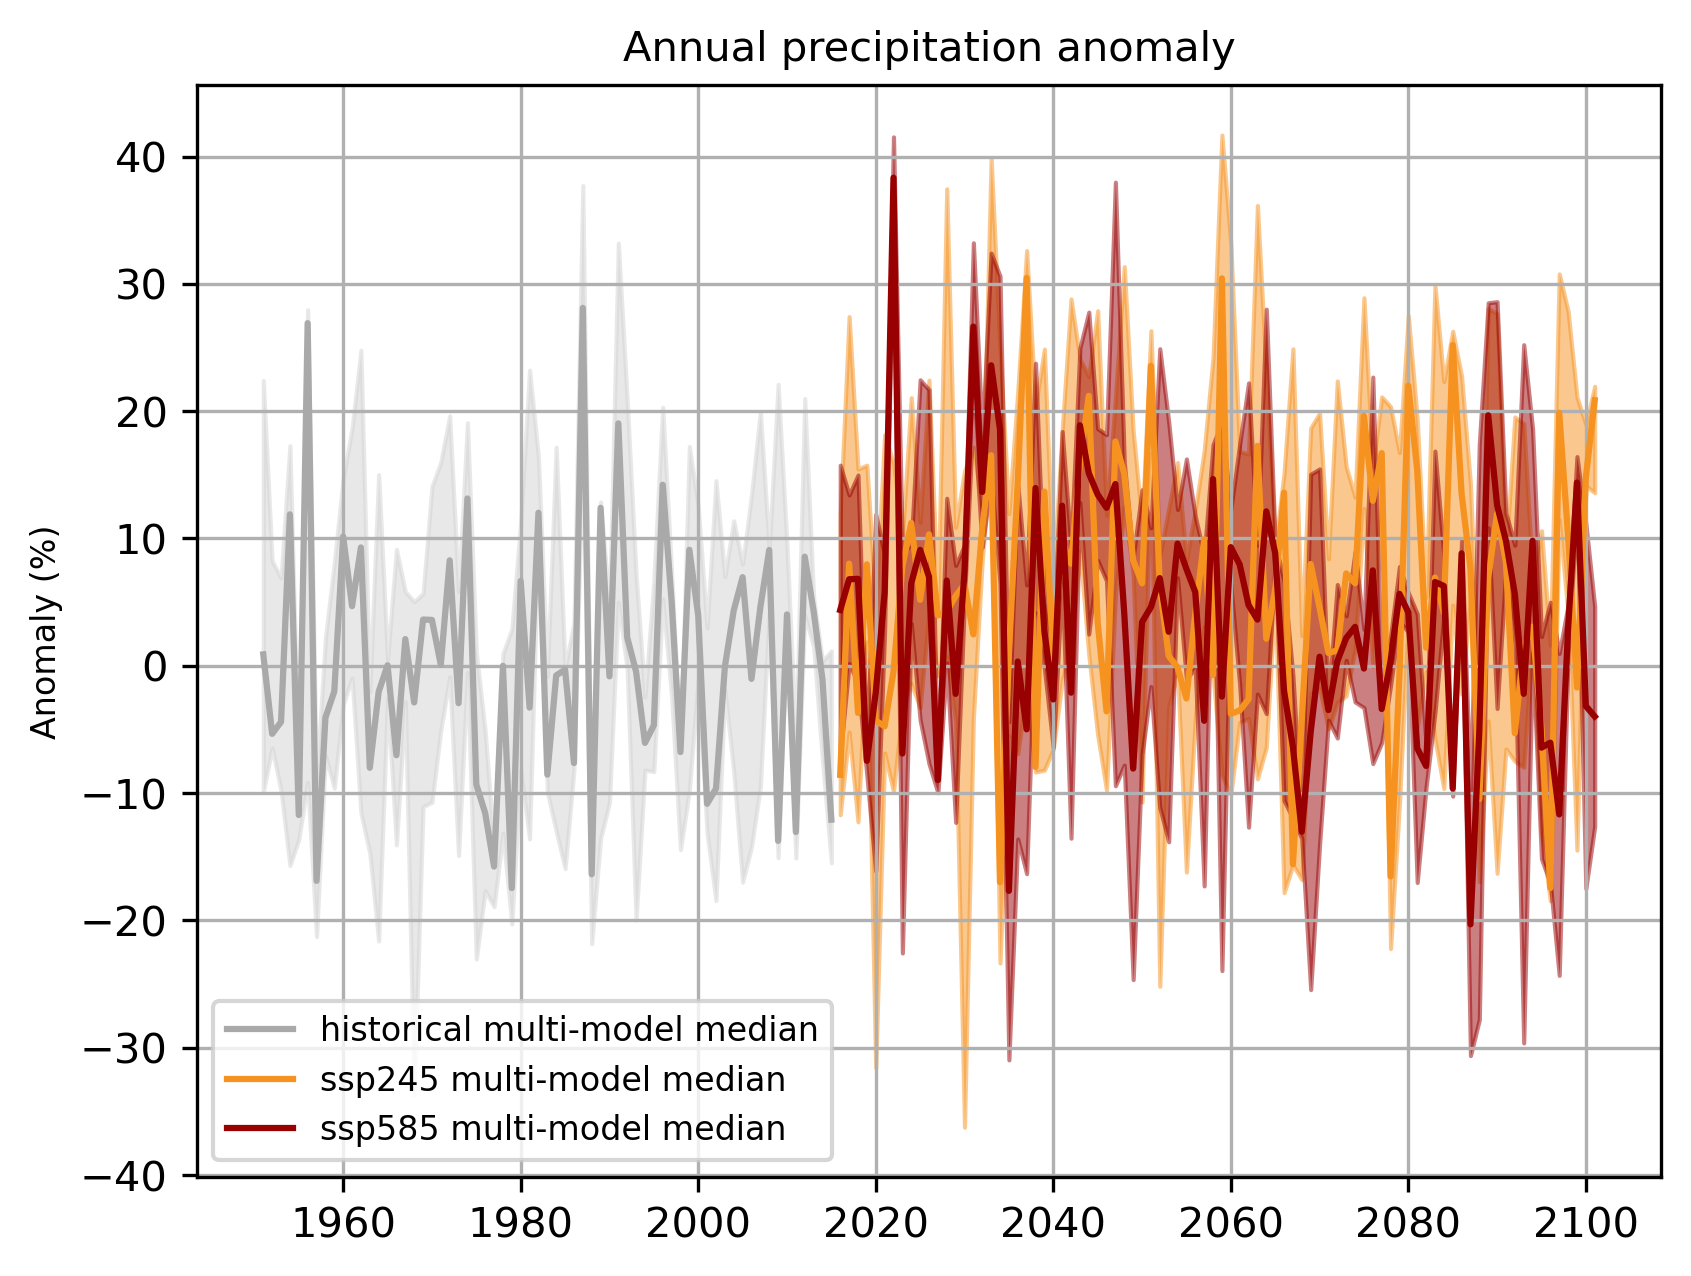

In [15]:
display.Image("./examples/myModel/plots/climate_projections/precip_anomaly_projections_anom.png")

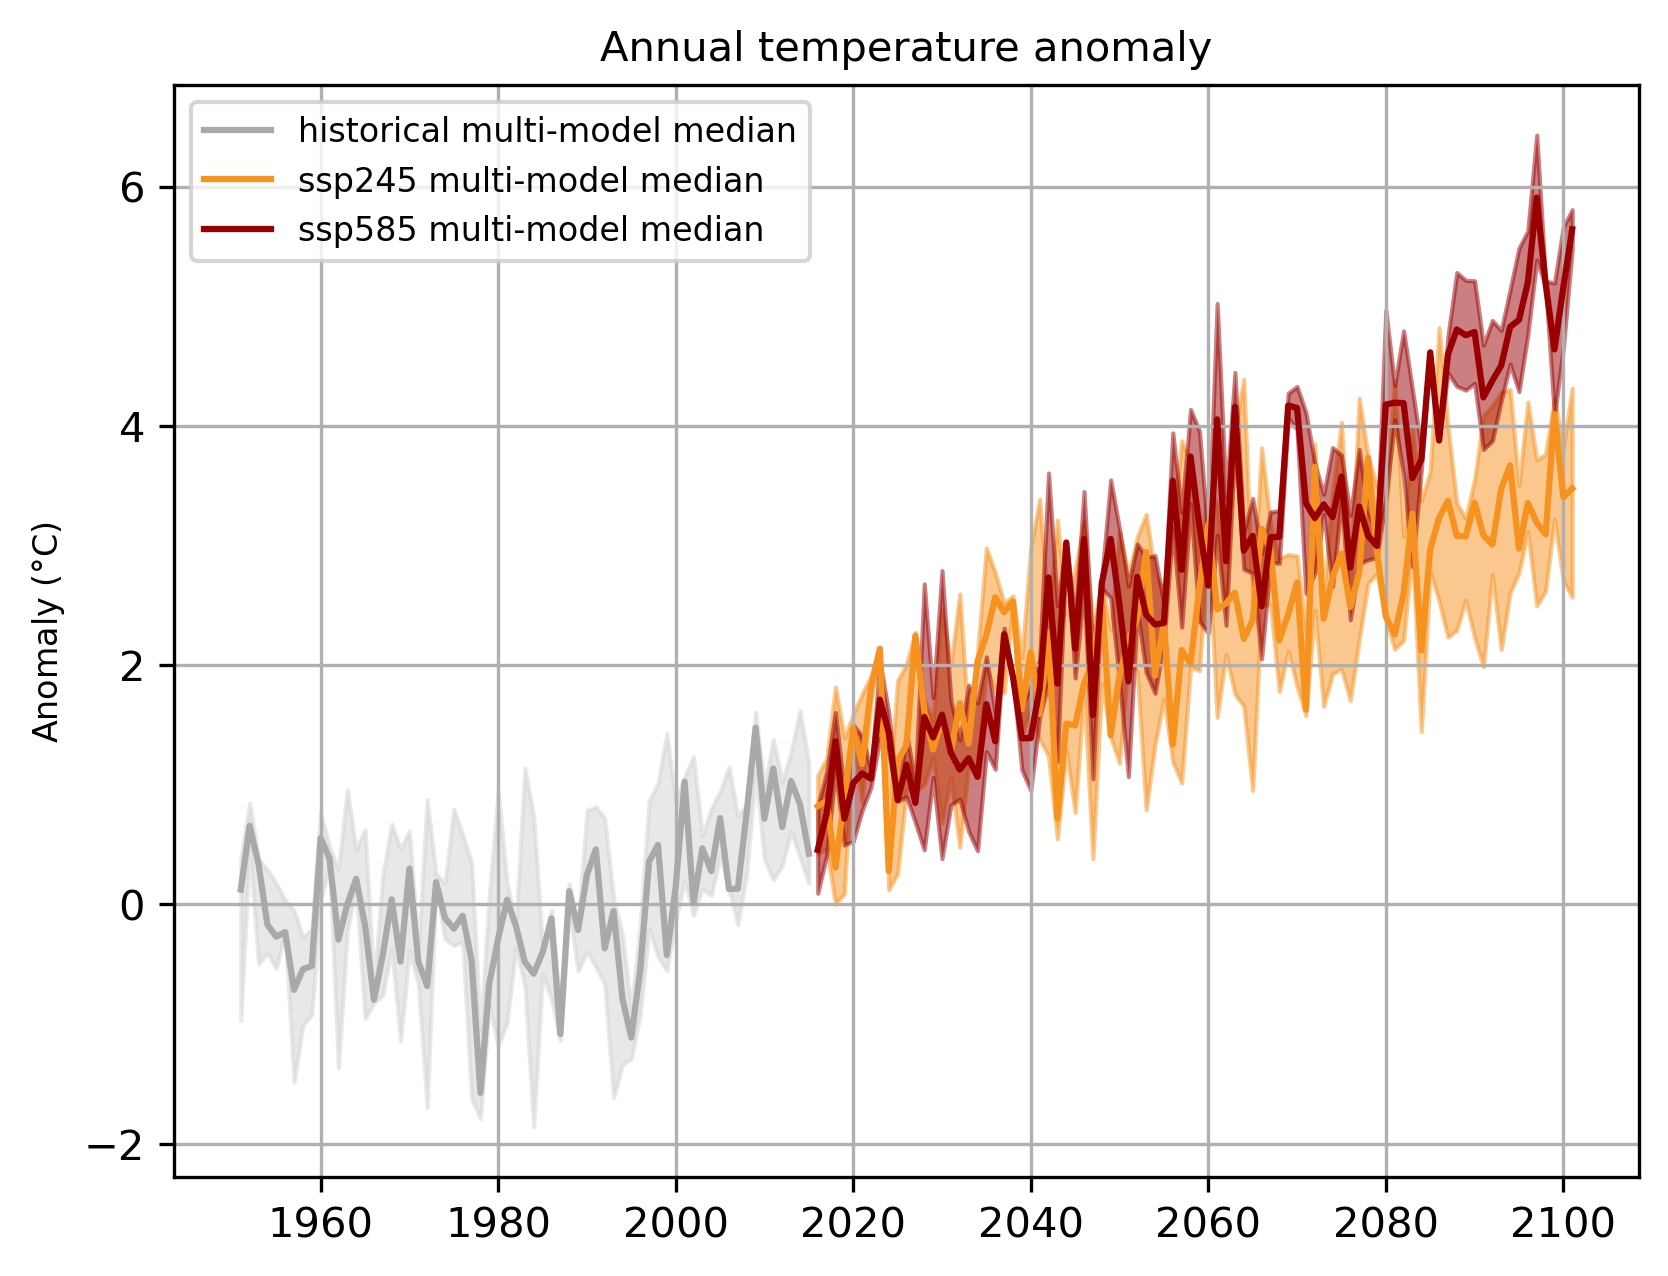

In [16]:
display.Image("./examples/myModel/plots/climate_projections/temp_anomaly_projections_anom.png")

For each climate model, scenario, member and future horizon, annual change in mean precipitation, temperature and potential evaporation is saved to a csv file, as shown below. 

In [17]:
import pandas as pd
df = pd.read_csv('examples/myModel/climate_projections/cmip6/annual_change_scalar_stats_summary_mean.csv')
df

,clim_project,model,member,horizon,scenario,stats,spatial_ref,pet,precip,temp
0,cmip6,CSIRO-ARCCSS_ACCESS-CM2,r1i1p1f1,far,ssp245,mean,0,18.624336,1.755634,3.469501
1,cmip6,CSIRO-ARCCSS_ACCESS-CM2,r1i1p1f1,far,ssp585,mean,0,NaN,NaN,NaN
2,cmip6,CSIRO-ARCCSS_ACCESS-CM2,r1i1p1f1,near,ssp245,mean,0,12.485099,8.117418,2.514417
3,cmip6,CSIRO-ARCCSS_ACCESS-CM2,r1i1p1f1,near,ssp585,mean,0,NaN,NaN,NaN
4,cmip6,INM_INM-CM5-0,r1i1p1f1,far,ssp245,mean,0,8.171658,2.588406,2.435583
5,cmip6,INM_INM-CM5-0,r1i1p1f1,far,ssp585,mean,0,13.830349,-5.636344,4.503333
6,cmip6,INM_INM-CM5-0,r1i1p1f1,near,ssp245,mean,0,7.129345,-2.559296,1.601666
7,cmip6,INM_INM-CM5-0,r1i1p1f1,near,ssp585,mean,0,8.475367,-2.289093,2.521417
8,cmip6,NOAA-GFDL_GFDL-ESM4,r1i1p1f1,far,ssp245,mean,0,12.822886,9.405801,2.262416
9,cmip6,NOAA-GFDL_GFDL-ESM4,r1i1p1f1,far,ssp585,mean,0,16.102940,6.557765,4.067000


In addition, the monthly gridded change factors for each climate model, scenario and future horizon are saved to netcdf files. An example of such a file for a specific model and scenario is shown below. 

In [18]:
gridded_change_factors = xr.open_dataset('examples/myModel/climate_projections/cmip6/monthly_change_grid/CSIRO-ARCCSS_ACCESS-CM2_ssp245_far.nc')
gridded_change_factors.squeeze()

<xarray.Dataset> Size: 1kB
Dimensions:       (lat: 2, lon: 2, month: 12)
Coordinates:
  * lat           (lat) float64 16B 46.88 45.62
  * lon           (lon) float64 16B 12.19 14.06
  * month         (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    spatial_ref   int32 4B ...
    clim_project  <U5 20B 'cmip6'
    model         <U23 92B 'CSIRO-ARCCSS_ACCESS-CM2'
    scenario      <U6 24B 'ssp245'
    member        <U8 32B 'r1i1p1f1'
    horizon       <U3 12B 'far'
Data variables:
    pet           (month, lat, lon) float32 192B ...
    precip        (month, lat, lon) float64 384B ...
    temp          (month, lat, lon) float32 192B ...

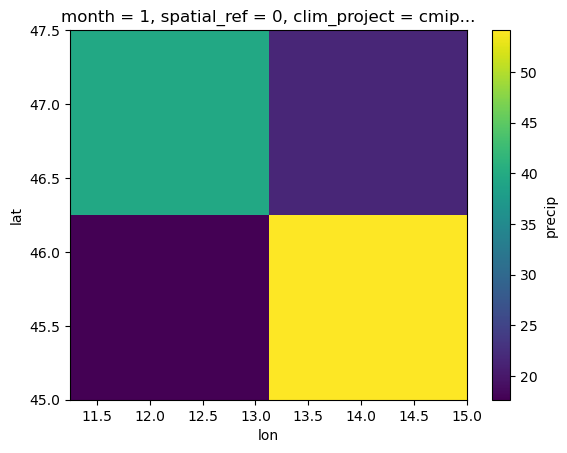

In [19]:
# Plot precipitation change [%] for January
var = "precip"
month = 1

gridded_change_factors[var].sel(month=month).plot()

The monthly gridded change factors will be used in the next workflow, which quantifies the impact of climate change on the hydrology (**Snakefile_future_hydrology_delta_change**). The workflow is explained in more detail in the next notebook *docs/notebooks/Hydrological projections.ipynb*.